## Policy Gradient in Reinforcement Learning (RL)

In this notebook we are going to train a model to play the Lunar Lander game. This is a particular game environment of the [gymnasium](https://gymnasium.farama.org/environments/box2d/lunar_lander/) API in which the objective is to safely land a rocket on the Moon. The player controls the rocket by using four discrete actions: fire main engine, fire left/right orientation engine or do nothing. At each instance, the agent observes the environment and reads an eight dimensional vector characterizing the current state of the rocket. After each step, a reward $r_t$ is provided which characterizes how close to how close the player is to winning the episode. An episode is considered to be solved when the total reward is above 200.

Given the state of the game $s_t$, a policy $\pi(s_t)$ corresponds to a probabilty distribution over the possible actions. We are going to consider the case in which the policy is built from a simple feedforward/fully-connected neural network $\pi_\theta(s_t)$ with parameters $\theta$. At each step, we sample from such distribution and in this way obtain an action $a_t$ which is then applied to the environment. Repeating this process, we obtain a particular trajectory $\tau=(s_0,a_0,s_1,a_1,\dots)$ which has an associated total reward $R(\tau)$. Put simply, the idea behind Policy Gradient is to update the network parameters $\theta$ is such a way that the total return $R(\tau)$ is maximized.

In the following, we are going to describe three different approaches of increased sophistication to apply Policy Gradient. We follow the introduction into RL provided [here](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html).

In [1]:
# Load packages
import numpy as np
import gymnasium as gym
# Load toygrad RLmodel and optimizer
from toygrad.nn.models import RLPolicyGradient
from toygrad.nn.optim import ADAM
# Set value for random seed
rnd_seed = 322

### Vanilla Policy Gradient: Take I

Let us start by initializing the Lunar Lander environment and the RLPolicyGradient model from the toygrad.nn.models module in this repository

In [2]:
# Initialize environment
env = gym.make("LunarLander-v2")
env.reset(seed=rnd_seed)

# Initialize policy
np.random.seed(rnd_seed)
obs_space_dim, act_space_dim = env.observation_space.shape[0], env.action_space.n
policy = RLPolicyGradient(env, obs_space_dim, act_space_dim)

The policy consists of a fully connected neural network with one hidden layer of dimension 128 and a ReLU activation function. Since the parameters of the network are initialized randomly, the agent does not know how to play the game properly and crashes the rocket

!["Title"](Untrained.gif?_ipython_update=20200718165242)

To train the policy, we are first going to use the simplest form of policy gradient, sometimes called "Vanilla Policy Gradient". The gradient of the mean return can be written as
$$\nabla_\theta E_{\tau\sim \pi_\tau}[R(\tau)] = \frac{1}{|\mathcal{B}|}\sum_{\tau \in \mathcal{B}}\sum_{t=0}^{T_\tau}\nabla_\theta \ln \pi_\theta(a_t|s_t)\hat{R}_t(\tau)$$
where $\mathcal{B}$ is a batch of trajectories $\tau$ sampled from our policy $\pi_\theta$. Here, $\hat{R}_t(\tau)$ sums all rewards obtained after the time step $t$
$$\hat{R}_t = \sum_{k=0}^{k_{\rm end}}\gamma^{k}r_{t+k}$$
where $\gamma\in(0,1]$ is a damping factor usually taken close to unity.

  0%|          | 0/300 [00:00<?, ?it/s]

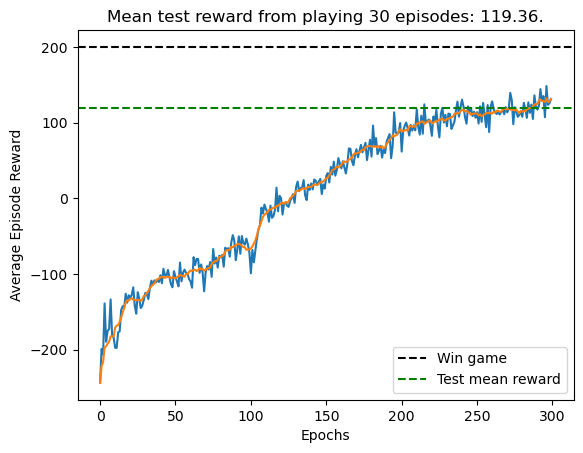

In [3]:
# Initialize environment
env = gym.make("LunarLander-v2")
env.reset(seed=rnd_seed)

# Initialize policy
np.random.seed(rnd_seed)
obs_space_dim, act_space_dim = env.observation_space.shape[0], env.action_space.n
policy = RLPolicyGradient(env, obs_space_dim, act_space_dim)

# Policy and value estimator optimizers training parameters
policy_optimizer = ADAM(policy.parameters, lr=5e-3, maximize=True)
value_optimizer = ADAM(policy.value_net.parameters, lr=5e-3)

# Train
out = policy.train_policy(batch_size=30, policy_epochs=300, policy_optimizer=policy_optimizer)

As we can see from the above plot, the model is clearly getting better at playing the game, although it wasn't able to get to the 200 mean reward required to beat it. Although this could be achieved by training for longer epochs and finetuning the hyperparameters, below we shall instead consider a more stable and faster approach for training the policy.

### Vanilla Policy Gradient: Take II

We can improve the performance of the policy gradient algorithm by using the following simple identity that holds for any probabilty distribution $P_\theta(x)$
$$\nabla_\theta \int dx P_\theta(x)=0 \qquad \Longrightarrow \qquad \int dx P_\theta(x)\nabla_\theta \ln P_\theta(x)=E[\nabla_\theta \ln P_\theta(x)]=0\ .$$

Applying this to the simple equation we used above for the gradient of the mean return $R(\tau)$ means one can instead write the gradient as

$$\nabla_\theta E_{\tau\sim \pi_\tau}[R(\tau)] = \frac{1}{|\mathcal{B}|}\sum_{\tau \in \mathcal{B}}\sum_{t=0}^{T_\tau}\nabla_\theta \ln \pi_\theta(a_t|s_t)\left[\hat{R}_t(\tau)-b(s_t)\right]$$
for an arbitrary function $b(s_t)$ which can be picked in order to ensure a faster and more stable training. One popular choice is to pick $b(s_t)$ such that the quantity between square brackets becomes the advantage $A^{\pi_\theta}(s_t,a_t)$, which roughly speaking quantifies how good/bad the action $a_t$ is on average compared to other possible actions.

An immediate problem is that directly computing $A^{\pi_\theta}(s_t,a_t)$ is very difficult. For this reason, we instead introduce an additional network $V_\phi(s_t)$ which we train in order to compute the on-policy value function $V^\pi(s_t)$ which can then be used to estimate the advantage (using [GAE](https://arxiv.org/pdf/1506.02438.pdf)). See [here](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#don-t-let-the-past-distract-you) for more details.

Applying this procedure, we train the policy again using the exact same hyperparameters as in the previous case.


  0%|          | 0/300 [00:00<?, ?it/s]

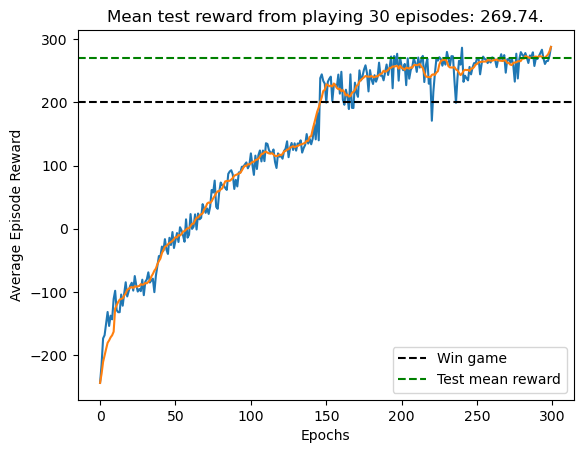

In [4]:
# Initialize environment
env = gym.make("LunarLander-v2")
env.reset(seed=rnd_seed)

# Initialize policy
np.random.seed(rnd_seed)
obs_space_dim, act_space_dim = env.observation_space.shape[0], env.action_space.n
policy = RLPolicyGradient(env, obs_space_dim, act_space_dim)

# Policy and value estimator optimizers training parameters
policy_optimizer = ADAM(policy.parameters, lr=5e-3, maximize=True)
value_optimizer = ADAM(policy.value_net.parameters, lr=5e-3)

# Train
out = policy.train_policy(batch_size=30, policy_epochs=300, policy_optimizer=policy_optimizer,
                          value_est=True, value_epochs=30, value_optimizer=value_optimizer,
                          lmbda=1.0, clip_eps=2e-1)

As we can see from the plot above, the training in this case was much more efficient. In the same number of epochs, we were able to win the game, attaining an average mean reward over 200 in testing.

### Proximal Policy Optimization (PPO)

We would like to finish by applying a more efficient algorithm called [Proximal Policy Optimization](https://arxiv.org/pdf/1707.06347.pdf). Instead of directly extremizing the expected return $E[R(\tau)]$, the idea is to consider the following surrogate objective function

$${\rm max}_{\theta}\quad E_{\tau \sim \pi_\theta}\left[{\rm min}\left(r_t(\theta)A_{t}, {\rm clip}\left(r_t(\theta), 1-\epsilon, 1 + \epsilon\right)A_t\right)\right] $$

where $r_t(\theta)=\frac{\pi_\theta(a_t|s_t)}{\pi_{\rm old}(a_t|s_t)}$. Here, $\pi_{\rm old}$ is the policy at the beginning of each epoch. Instead of just doing a single update on the policy in order to maximize the objective function above, one performs several updates. The idea behind the 'clip' function and the hyperparameter $\epsilon$ is to prevent the updates to make very big updates of the policy which make the new policy too different from the old one. Applying this modification to our model, we can train our policy one more time using the same hyperparameters as in the previous cases.

  0%|          | 0/80 [00:00<?, ?it/s]

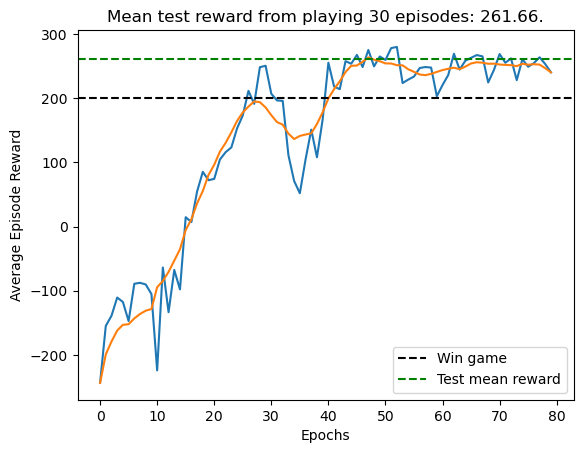

In [5]:
# Initialize environment
env = gym.make("LunarLander-v2")
env.reset(seed=rnd_seed)

# Initialize policy
np.random.seed(rnd_seed)
obs_space_dim, act_space_dim = env.observation_space.shape[0], env.action_space.n
policy = RLPolicyGradient(env, obs_space_dim, act_space_dim)

# Policy and value estimator optimizers training parameters
policy_optimizer = ADAM(policy.parameters, lr=5e-3, maximize=True)
value_optimizer = ADAM(policy.value_net.parameters, lr=5e-3)

# Train
out = policy.train_policy(batch_size=30, policy_epochs=80, policy_optimizer=policy_optimizer,
                          value_est=True, value_epochs=30, value_optimizer=value_optimizer,
                          lmbda=1.0, clip_eps=2e-1,
                          PPO=True, PPO_epochs=15, kl_eps=0.050)

From the plot above, we note the policy learned how to play the game much more efficiently than the previous cases. Apart from running 80 epochs instead of 300, the running time itself was less than half. Below, we show an example of how the trained model can play (and win) an episode of the Lunar Lander game.

!["Title"](Trained.gif?_ipython_update=20200718165242)